## FWI: $ F_0 = 15.0 $ $s^{-1}$ 
Restart the Kernel before the next Run

Generating observed data...


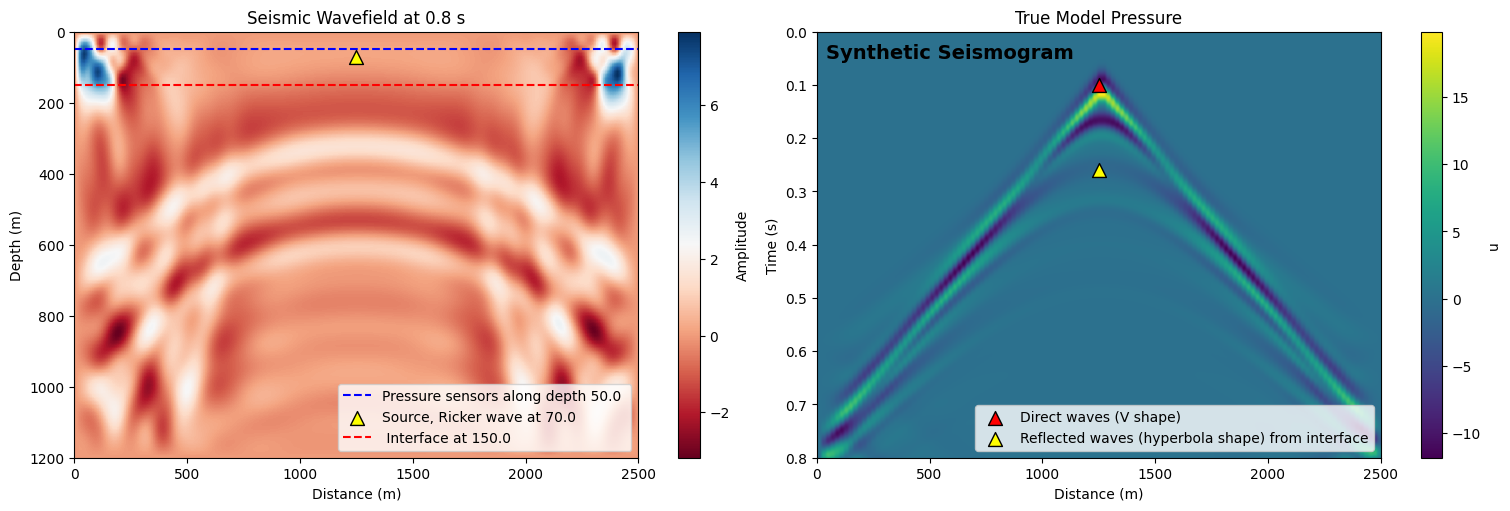

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# 1. Physical & Grid Parameters
nx, nz = 250, 120 
dx, dz = 10.0, 10.0
nt = 800 # 800 
dt = 0.001
f0 = 15.0 

# --- Sponge Layer (Damp Wall) Setup ---
npad = 20 # 20 # Thickness of the damp wall
v_damp = np.ones((nx, nz))
damp_factor = 0.01 # 0.01 # Strength of the sponge

for i in range(npad):
    # Quadratic decay towards the edges
    amplitude = 1.0 - (damp_factor * (npad - i)**2 / npad**2)
    v_damp[i, :] *= amplitude          # Left
    v_damp[-(i+1), :] *= amplitude     # Right
    v_damp[:, -(i+1)] *= amplitude     # Bottom

# 2. Source Setup
time = np.arange(nt) * dt
tau = np.pi * f0 * (time - 1.5/f0)
source = (1 - 2*tau**2) * np.exp(-tau**2)

# 3. Create True Model and Initial Guess
v_true = np.full((nx, nz), 2000.0)
v_true[:, 15:] = 3000.0  # Horizontal boundary 

v_current = np.full((nx, nz), 1900.0) # Starting guess (slightly off)

def get_seis(vel):
    """Standard Forward Modeling"""
    u_p, u_n = np.zeros((nx, nz)), np.zeros((nx, nz))
    seis = np.zeros((nt, nx))
    v2dt2 = (vel**2 * dt**2)
    inv_h2 = 1.0 / dx**2
    
    for n in range(nt):
        # Laplacian using slicing 
        lap = np.zeros_like(u_n)
        lap[1:-1, 1:-1] = (u_n[2:, 1:-1] + u_n[:-2, 1:-1] + 
                           u_n[1:-1, 2:] + u_n[1:-1, :-2] - 4*u_n[1:-1, 1:-1]) * inv_h2
        
        u_next = 2*u_n - u_p + v2dt2 * lap
        u_next[nx//2, 7] += source[n] * v2dt2[nx//2, 7]
        
        u_next *= v_damp # --- APPLY SPONGE ---
        
        seis[n, :] = u_next[:, 5] # Receivers at z=5
        u_p, u_n = u_n, u_next
    return seis, u_n

# 4. Generate the "Field Data" we are trying to match
print("Generating observed data...")
d_obs, u_nF = get_seis(v_true)

fig, ax = plt.subplots(1, 2, figsize=(15, 5), layout="constrained") 

im1 = ax[0].imshow(u_nF.T, cmap='RdBu', aspect='auto', extent=[0, nx*dx, nz*dx, 0])

ax[0].axhline(y=5*dx, color='b', linestyle='--', label=f"Pressure sensors along depth {5*dx} ")
ax[0].scatter(nx*dx/2, 7*dx, marker='^', color='yellow', 
              s=100, edgecolors='black', label= f"Source, Ricker wave at {7*dx}" , zorder=10)
ax[0].axhline(y=15*dx, color='r', linestyle='--', label=f" Interface at {15*dx}")
ax[0].legend(loc='lower right')
ax[0].set_title(f"Seismic Wavefield at {nt*dt} s")
ax[0].set_xlabel("Distance (m)")
ax[0].set_ylabel("Depth (m)")
fig.colorbar(im1, ax=ax[0], label="Amplitude", fraction=0.046, pad=0.04)

im2 = ax[1].imshow(d_obs[::2, ::2], aspect='auto', extent=[0, nx*dx, nt*dt, 0])

ax[1].annotate('Synthetic Seismogram ', 
            xy=(40, 0.05), xytext=(40, 0.05),
            color='black', fontsize=14, fontweight='bold')
ax[1].scatter(nx*dx/2, 0.1, marker='^', color='red', 
              s=100, edgecolors='black', label= f"Direct waves (V shape)" , zorder=10)
ax[1].scatter(nx*dx/2, 0.26, marker='^', color='yellow', 
              s=100, edgecolors='black', label= f"Reflected waves (hyperbola shape) from interface" , zorder=10)
ax[1].legend(loc='lower right')
ax[1].set_title("True Model Pressure")
ax[1].set_xlabel("Distance (m)")
ax[1].set_ylabel("Time (s)")
fig.colorbar(im2, ax=ax[1], label="u", fraction=0.046, pad=0.04)

#plt.savefig('FWI_1.png', bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()

Starting 30 iterations of FWI...
Starting 0th iteration of FWI...
Starting 10th iteration of FWI...
Starting 20th iteration of FWI...


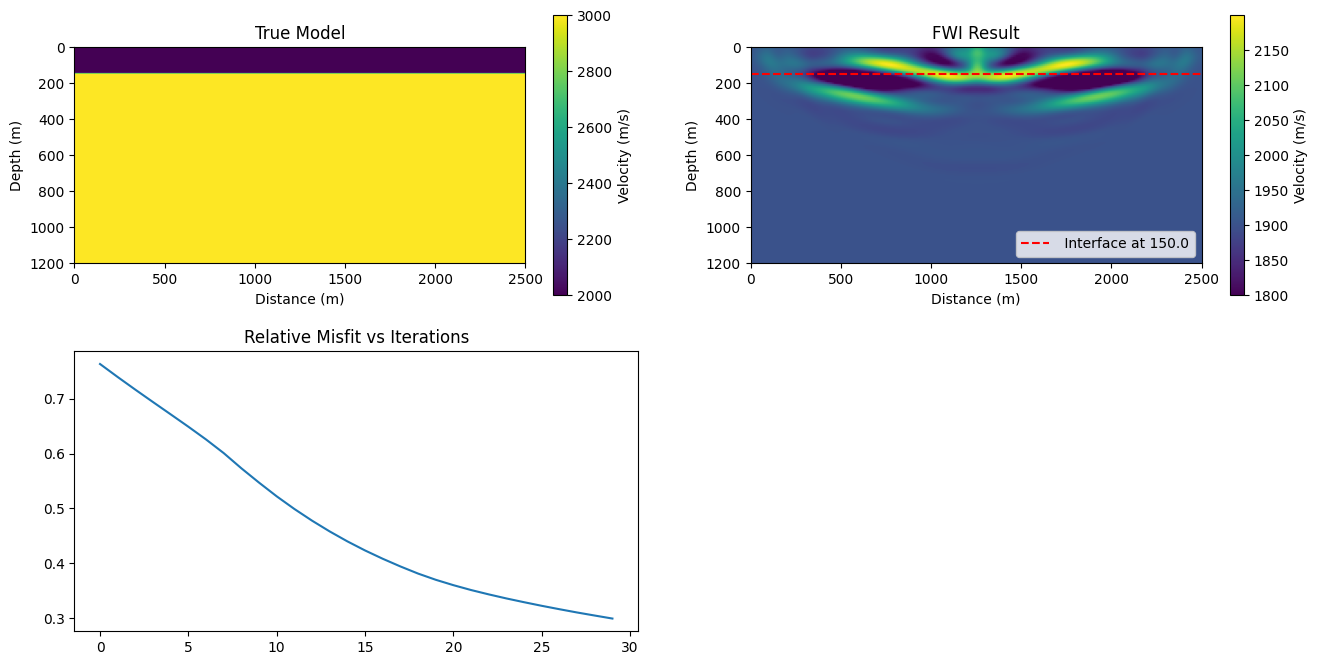

In [2]:
# --- Baseline for Normalization ---
# Calculate the energy of the observed data to use as a 100% scale
initial_data_energy = np.sum(d_obs**2) / 2

n_iterations = 30
step_length = 16 # with smoothed grad ( 1e5 without smooth) 

misfit_history = []
relative_misfit_history = []

# 5. FWI Main Loop
print(f"Starting {n_iterations} iterations of FWI...")
for i in range(n_iterations):
    if i % 10 == 0:
        print(f"Starting {i}th iteration of FWI...")
    # --- STEP A: Forward Modeling ---
    u_p, u_n = np.zeros((nx, nz)), np.zeros((nx, nz))
    u_history = np.zeros((nt, nx, nz)) # Store wavefield for gradient
    seis_syn = np.zeros((nt, nx))
    v2dt2 = (v_current**2 * dt**2)
    
    for n in range(nt):
        lap = np.zeros_like(u_n)
        lap[1:-1, 1:-1] = (u_n[2:, 1:-1] + u_n[:-2, 1:-1] + 
                           u_n[1:-1, 2:] + u_n[1:-1, :-2] - 4*u_n[1:-1, 1:-1]) / dx**2
        u_next = 2*u_n - u_p + v2dt2 * lap
        u_next[nx//2, 7] += source[n] * v2dt2[nx//2, 7] # Source must be the same as in  Forward
        
        u_next *= v_damp # --- APPLY SPONGE ---
        
        u_history[n] = u_n # Save state for adjoint
        seis_syn[n, :] = u_next[:, 5]
        u_p, u_n = u_n, u_next

    # --- STEP B: Calculate Residuals & Misfit ---
    residuals = d_obs - seis_syn 
    misfit = np.sum(residuals**2) /2 # J(v) the success metric is the Least Square   
    misfit_history.append(misfit)
    
    # Normalized Misfit (Percentage of initial error remaining)
    norm_misfit = misfit / initial_data_energy
    relative_misfit_history.append(norm_misfit)
    
    # --- STEP C: Adjoint Modeling (Back-propagation) ---
    adj_p, adj_n = np.zeros((nx, nz)), np.zeros((nx, nz))
    gradient = np.zeros((nx, nz))
    
    for n in range(nt-1, -1, -1): 
        lap = np.zeros_like(adj_n)
        lap[1:-1, 1:-1] = (adj_n[2:, 1:-1] + adj_n[:-2, 1:-1] + 
                           adj_n[1:-1, 2:] + adj_n[1:-1, :-2] - 4*adj_n[1:-1, 1:-1]) / dx**2
        adj_next = 2*adj_n - adj_p + v2dt2 * lap
        adj_next[:, 5] += residuals[n, :] * v2dt2[:, 5] # Inject source = dJ/du (which is the residual) at receivers
        
        adj_next *= v_damp # --- APPLY SPONGE TO ADJOINT ---

        # Gradient computation: dJ/dv = - Integral_t [dL/dv u lambda] dt
        # L is the wave equation operator, (1/v^2)d_tt - d_xx 
        # v is the velocity; u is the forwards field; Lambda is the adjoint field;  dL/dv = (-2/v^3)d_tt
        # dJ/dv = - (2/v^3) * Integral_t ( d_tt u * Lambda ) dt
        # Using a simplified approximation for velocity sensitivity in space (common in FWI): d_tt u = u
        # dJ/dv = - (2/v^3) * Summation( Lambda *u ) along time
        gradient += (adj_n * u_history[n]) * (2.0 / (np.abs(v_current)**3 + 1e-10)) # (adj_n * u_history[n]) Hadamard product
         
        adj_p, adj_n = adj_n, adj_next

    # --- STEP D: Robust Update Model ---
    
    # A. Pre-process Gradient
    # Remove source artifacts and smooth
    grad_smoothed = gaussian_filter(gradient, sigma=3.0)
    # B. Normalize (Prevents the '1e5' explosion)
    grad_norm = grad_smoothed / (np.max(np.abs(grad_smoothed)) + 1e-10)
    
    # C. Update the velocity
    v_current = v_current - step_length * grad_norm  

    # D. SAFETY CLIPPING
    # Prevent negative velocities or extreme values that cause 'nan'
    v_current = np.clip(v_current, 1800.0, 3500.0)
    # E. DYNAMIC STABILITY CHECK
    max_v = np.max(v_current)
    cfl = max_v * dt / dx
    if cfl > 0.707:
        print(f"CRITICAL: Iteration {i} is unstable! CFL={cfl:.2f}")
        # Force velocity down to maintain stability
        v_current = v_current * (0.7 / cfl)

# 6. Final Visualization
plt.figure(figsize=(16, 8))
plt.subplot(221); plt.imshow(v_true.T, cmap='viridis',extent=[0, nx*dx, nz*dx, 0]); plt.title("True Model")
plt.colorbar(label="Velocity (m/s)"); plt.xlabel("Distance (m)"); plt.ylabel("Depth (m)")
plt.subplot(222); plt.imshow(v_current.T, cmap='viridis',extent=[0, nx*dx, nz*dx, 0]); plt.title(f"FWI Result");
plt.colorbar(label="Velocity (m/s)"); plt.xlabel("Distance (m)"); plt.ylabel("Depth (m)")
plt.axhline(y=15*dx, color='r', linestyle='--', label=f" Interface at {15*dx}"); plt.legend(loc='lower right')
plt.subplot(223); plt.plot(relative_misfit_history); plt.title("Relative Misfit vs Iterations")
plt.show()